# Content

* [Loading Data](#0)
* [Preprocessing the Data](#1)
* [EDA Section](#2)
* [Hyperparameter Tuning for Different Models](#3)
    * [Linear Regression Models](#3.1)
        * [Model 1: Linear Regression on charges](#3.1.1)
        * [Model 2: Linear Regression on log(charges)](#3.1.2)
    * [Non-Linear Regression Models](#3.2)
        * [Model 3: KNN Regression](#3.2.1)
        * [Model 4: Random Forest Regression](#3.2.2)
        * [Model 5: AdaBoost Regression](#3.2.3)
        * [Model 6: LightGBM Regression](#3.2.4)
* [Compare Different Regression Models on Test Data](#4)
    * [True Values VS Predicted Values](#4.1)    
    * [Distribution of Sqaured Errors](#4.2)
    * [Coefficients for Linear Regression Models](#4.3)
    * [Feature Importance for Tree Dicision Models](#4.4)
    * [Comparison of MSEs and R-squares](#4.5)
* [Summary](#5)


# Loading Data

First we load the data from https://open-data.s3.filebase.com/insurance.csv and look at the structure. There are 6 features: [*age, sex, bmi, children, smoker, region*] and 1 response: *charges*. Among the 6 features, *sex, smoker* and *region* are **categorical features**; *age* and *children* are **ordinal features**; *bmi* is **continuous feature**. There are in total 1338 records of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import warnings
from pyparsing.core import enable_all_warnings
warnings.simplefilter("ignore")

# load the data
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [2]:
df.shape

(1338, 7)

In [3]:
#Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Preprocessing the Data

In the preprocessing phase, we first using the package missingno to check if there are any missing values in the dataframe. The following graph shows no white spaces, meaning there is no missing values in the dataset. Therefore we do not need to do any data imputation.

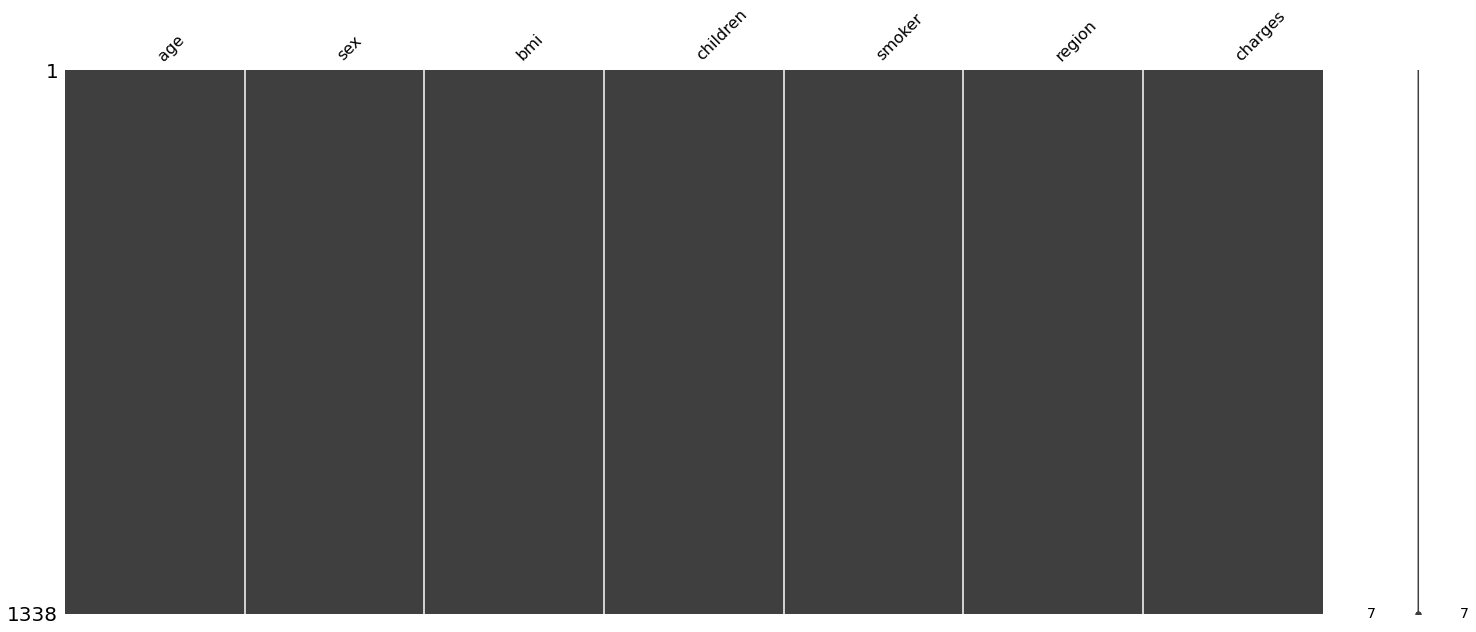

In [4]:
# no missing value
ms.matrix(df)

Now we are ready to convert unstructured data. We notice that *sex* and *smoker* are **categorical features** and they have only 2 values so we can transfer them into binary code: 0 and 1. As for *region*, it has 4 values and they are not ordinal so we need to use one-hot-encoding. That will add 3 columns in the original dataframe. (See the new dataframe below)

In [5]:
# preprocessing
df.sex=df.sex.map({'female':0, 'male':1}) # convert string to int for linear regression
df.smoker=df.smoker.map({'no':0, 'yes':1}) 
df = df.join(pd.get_dummies(df.region)) # one-hot-encoding
df=df.drop('region',axis=1) #drop the original column
df.head(5)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


# EDA Section

We plot the histograms for each column data and find the plots of *age, bmi* and *charges* interesting. The distribution of* age* seems like a uniform distribution and the distribution of *bmi* seems like a normal distribution. These pattern might give us some clue when doing the data scaling for linear regression models and KNN model. In addition, we notice the distribution of charges is similar to an exponential distribution. In linear regression, we usually assume the innovation comforms to normal distribution so we naturally consider take the log of the *charges* column.

In addition, we find no obvious evidence for outliers in our data according to the histograms.

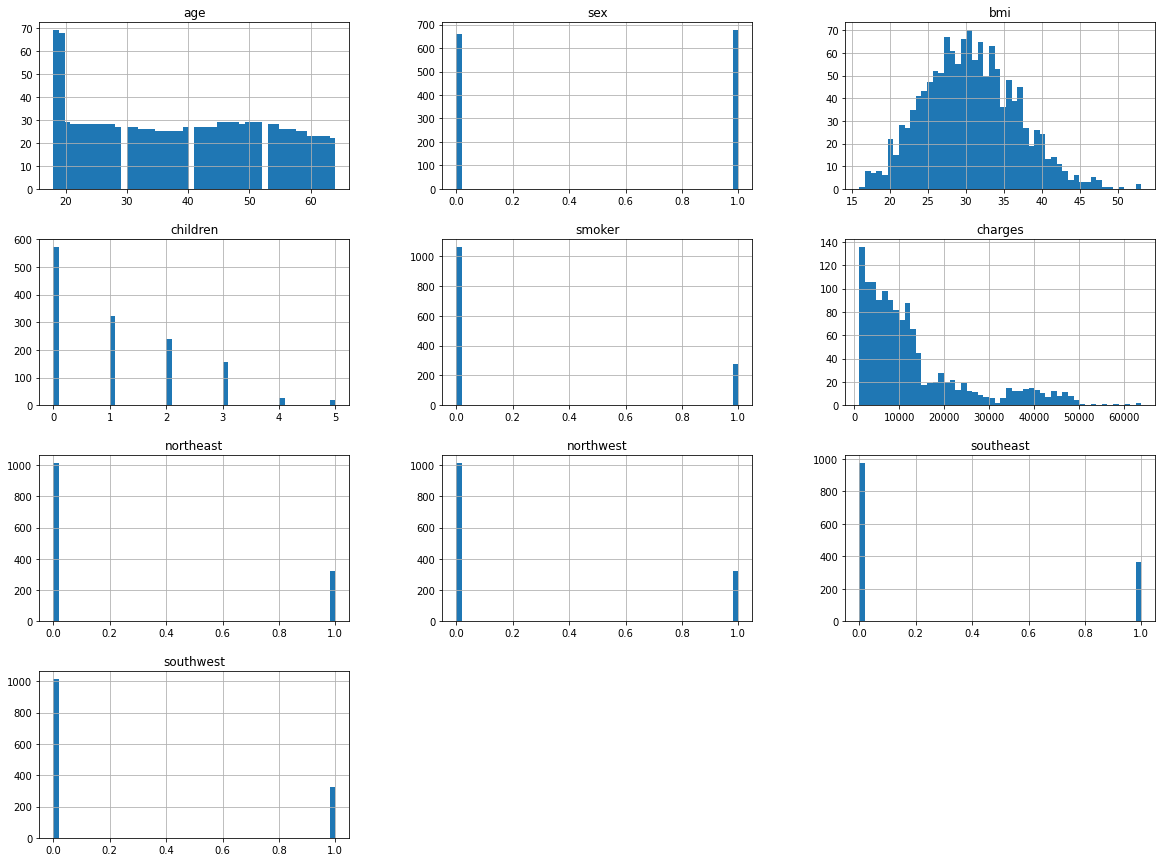

In [6]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Below is the distribution of *log(charges)*. We can see it becomes more like a normal distribution. We exploit this pattern in our second model.

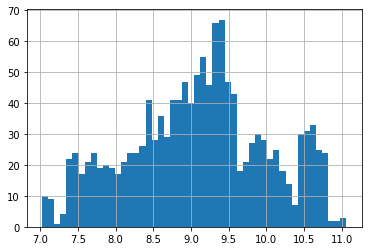

In [7]:
np.log(df['charges']).hist(bins=50)
plt.show()

Next we look at the correlations among all the columns in the dataframe. From the graph below we see *age, bmi* and *smoker* are the three features having largest correlation with the response *charges*, especially for the *smoker* feature, which makes sense since smokers usually have worse health conditions and will be charged more money for insurance. Other features have little correlation with the response.

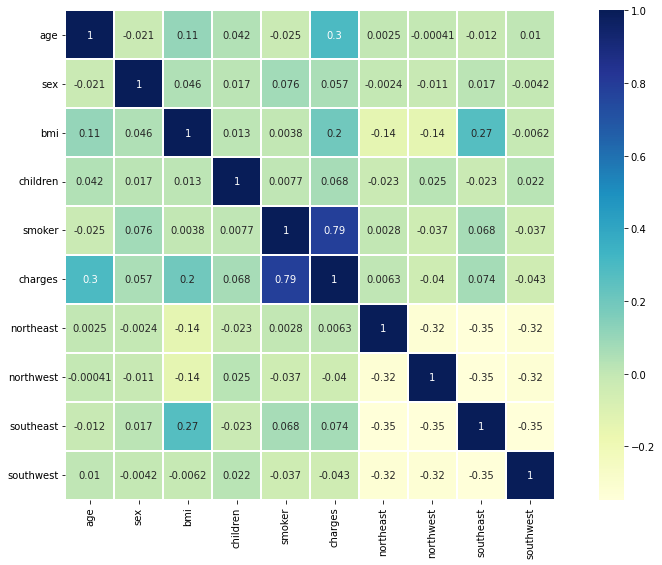

In [8]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), cmap="YlGnBu",annot=True, fmt=".2g", linewidths = 1, square= True)

Summary of data. The standard deviation of *charges* is very huge.

In [9]:
# look  describe data set
df.describe().round(2)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
count,1338.00,1338.00,1338.00,1338.00,1338.0,1338.00,1338.00,1338.00,1338.00,1338.00
mean,39.21,0.51,30.66,1.09,0.2,13270.42,0.24,0.24,0.27,0.24
std,14.05,0.50,6.10,1.21,0.4,12110.01,0.43,0.43,0.45,0.43
min,18.00,0.00,15.96,0.00,0.0,1121.87,0.00,0.00,0.00,0.00
25%,27.00,0.00,26.30,0.00,0.0,4740.29,0.00,0.00,0.00,0.00
50%,39.00,1.00,30.40,1.00,0.0,9382.03,0.00,0.00,0.00,0.00
75%,51.00,1.00,34.69,2.00,0.0,16639.91,0.00,0.00,1.00,0.00
max,64.00,1.00,53.13,5.00,1.0,63770.43,1.00,1.00,1.00,1.00


The following figures indicates that difference *sex* values does not impact proportion of other features like *smoker* and *children* (actually also *region*).

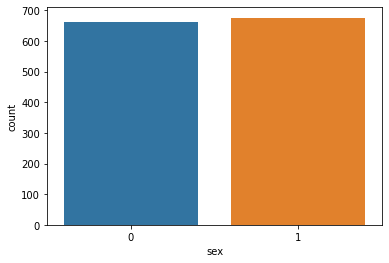

In [10]:
sns.countplot(x='sex', data=df)

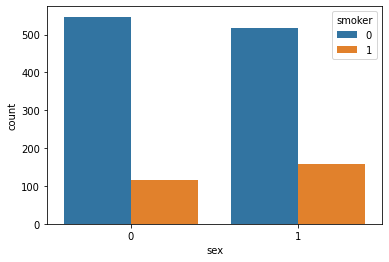

In [11]:
sns.countplot(x='sex', hue = 'smoker', data=df)

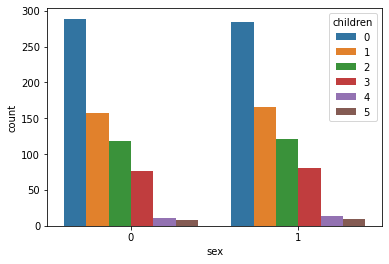

In [12]:
sns.countplot(x='sex', hue = 'children', data=df)

# Hyperparameter Tuning for Different Models

First we import necessary packages and divide the original data into training set and testing set.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor


# split X and y 
X = df.drop('charges', axis = 1)
y = df['charges']


# split the train and test data
test_size = 0.2
seed = 11
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
#reset index for cv
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
num_folds = 5


## Linear Regression Models

### Model 1: Linear Regression on charges


The first model is the simplest linear regression model using the *charge* column as our response. Here we first do scaling/normalization on *bmi* and *age* features to accelerate the optimization process. In the EDA section, we have found that the distribution of *age* is like uniform and the distribution of *bmi* is like normal, so for the *age* feature we do min-max normalization and for the *bmi* feature we do standardization. In order to avoid information leaks, we fit the scaler only on training data, and use the fitted scaler to transform both training data and validation data. To find the best linear model, we try 3 different regularizations: Lasso, Ridge and ElasticNet with different alpha values, and use 5-fold cross-validation to estimate the test mean squared error for each model. The model gave the smallest MSE was chosen.

In [14]:
cv = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
scaler_s = StandardScaler() # scaler for 'bmi' column
scaler_m = MinMaxScaler() # scaler for 'age' column
num_alpha = 21
alpha_grid = np.linspace(0, 50, num=num_alpha)
alpha_r2 = np.zeros(shape=(3, num_alpha))
alpha_mse = np.zeros(shape=(3, num_alpha))

for num, alpha in enumerate(alpha_grid):
    r2s = np.zeros(shape=(3, num_folds))
    mses = np.zeros(shape=(3, num_folds))
    for count, data in enumerate(cv.split(X_train)):
        train = data[0]; validation = data[1]
        x_t, x_v = X_train.iloc[train,:], X_train.iloc[validation,:]
        y_t, y_v = y_train[train], y_train[validation]

        # first do scaling on the training data (fit and transform)
        new_bmi = scaler_s.fit_transform(x_t[['bmi']])
        new_age = scaler_m.fit_transform(x_t[['age']])
        x_t['bmi'] = new_bmi
        x_t['age'] = new_age

        model_l2 = Ridge(alpha = alpha) # L2 regularization
        model_l1 = Lasso(alpha = alpha) # L1 regularization
        model_l1_l2 = ElasticNet(alpha = alpha) #L1 and L2 regularization
        model_l2.fit(x_t, y_t)
        model_l1.fit(x_t, y_t)
        model_l1_l2.fit(x_t, y_t)

        # use information in the training data to scale the validation data (transform)
        new_bmi2 = scaler_s.transform(x_v[['bmi']])
        new_age2 = scaler_m.transform(x_v[['age']])
        x_v['bmi'] = new_bmi2
        x_v['age'] = new_age2

        # make prediction and calculate MSE and R^2
        # Lasso:
        y_pred = model_l1.predict(x_v)
        mse = mean_squared_error(y_v, y_pred)
        r2 = r2_score(y_v, y_pred)
        mses[0][count] = mse
        r2s[0][count] = r2
        #Ridge:
        y_pred = model_l2.predict(x_v)
        mse = mean_squared_error(y_v, y_pred)
        r2 = r2_score(y_v, y_pred)
        mses[1][count] = mse
        r2s[1][count] = r2
        # Elastic Net:
        y_pred = model_l1_l2.predict(x_v)
        mse = mean_squared_error(y_v, y_pred)
        r2 = r2_score(y_v, y_pred)
        mses[2][count] = mse
        r2s[2][count] = r2

    alpha_mse[0][num] = np.mean(mses[0])
    alpha_r2[0][num] = np.mean(r2s[0])
    alpha_mse[1][num] = np.mean(mses[1])
    alpha_r2[1][num] = np.mean(r2s[1])
    alpha_mse[2][num] = np.mean(mses[2])
    alpha_r2[2][num] = np.mean(r2s[2])


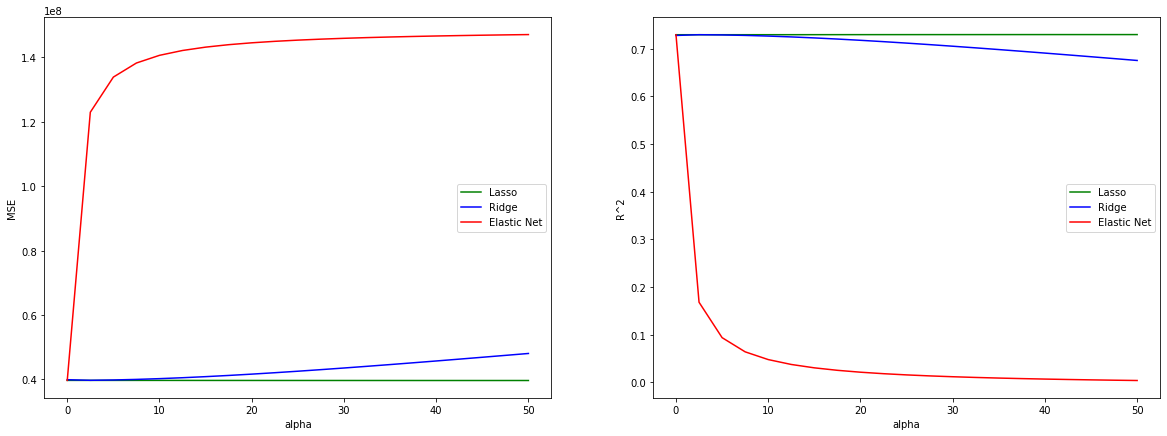

In [15]:
# plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(alpha_grid, alpha_mse[0], color='green', label='Lasso')
ax1.plot(alpha_grid, alpha_mse[1], color='blue', label='Ridge')
ax1.plot(alpha_grid, alpha_mse[2], color='red', label='Elastic Net')
ax1.legend()
ax1.set_xlabel('alpha')
ax1.set_ylabel('MSE')

ax2.plot(alpha_grid, alpha_r2[0], color='green', label='Lasso')
ax2.plot(alpha_grid, alpha_r2[1], color='blue', label='Ridge')
ax2.plot(alpha_grid, alpha_r2[2], color='red', label='Elastic Net')
ax2.legend()
ax2.set_xlabel('alpha')
ax2.set_ylabel('R^2')
plt.show()

In [16]:
np.min(alpha_mse, axis=1) # Lasso regression gives the best mse compared with Ridge and Elastic Net

array([39684546.90046079, 39746886.16189867, 39720352.18371005])

In [17]:
alpha_grid[np.argmin(alpha_mse, axis=1)[0]] # Lasso regression with alpha = 45 gives the best mse

45.0

### Model 2: Linear Regression on log(charges)

The second model is most the same as the first one except the response now becomes the *log(charges)*. Since in the EDA section we found the distribution of *charges* is very similar to exponential which violate the normality assumption of linear regression, we take log on the charges column and use it as our new response. Notice that the predictions of this model is still the logged version so we need to exponentiate them and then calculate the MSE, otherwise we cannot compare its MSE with other models.

In [18]:
cv = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
scaler_s = StandardScaler() # scaler for 'bmi' column
scaler_m = MinMaxScaler() # scaler for 'age' column
num_alpha = 21
alpha_grid = np.linspace(0, 50, num=num_alpha)
alpha_r2 = np.zeros(shape=(3, num_alpha))
alpha_mse = np.zeros(shape=(3, num_alpha))

for num, alpha in enumerate(alpha_grid):
    r2s = np.zeros(shape=(3, num_folds))
    mses = np.zeros(shape=(3, num_folds))
    for count, data in enumerate(cv.split(X_train)):
        train = data[0]; validation = data[1]
        x_t, x_v = X_train.iloc[train,:], X_train.iloc[validation,:]
        y_t, y_v = y_train[train], y_train[validation]

        # first do scaling on the training data (fit and transform)
        new_bmi = scaler_s.fit_transform(x_t[['bmi']])
        new_age = scaler_m.fit_transform(x_t[['age']])
        x_t['bmi'] = new_bmi
        x_t['age'] = new_age

        model_l2 = Ridge(alpha = alpha) # L2 regularization
        model_l1 = Lasso(alpha = alpha) # L1 regularization
        model_l1_l2 = ElasticNet(alpha = alpha) #L1 and L2 regularization
        model_l2.fit(x_t, np.log(y_t))
        model_l1.fit(x_t, np.log(y_t))
        model_l1_l2.fit(x_t, np.log(y_t))

        # use information in the training data to scale the validation data (transform)
        new_bmi2 = scaler_s.transform(x_v[['bmi']])
        new_age2 = scaler_m.transform(x_v[['age']])
        x_v['bmi'] = new_bmi2
        x_v['age'] = new_age2

        # make prediction and calculate MSE and R^2
        # Lasso:
        log_y_pred = model_l1.predict(x_v)
        mse = mean_squared_error(y_v, np.exp(log_y_pred))
        r2 = r2_score(np.log(y_v), log_y_pred)
        mses[0][count] = mse
        r2s[0][count] = r2
        #Ridge:
        log_y_pred = model_l2.predict(x_v)
        mse = mean_squared_error(y_v, np.exp(log_y_pred))
        r2 = r2_score(np.log(y_v), log_y_pred)
        mses[1][count] = mse
        r2s[1][count] = r2
        # Elastic Net:
        log_y_pred = model_l1_l2.predict(x_v)
        mse = mean_squared_error(y_v, np.exp(log_y_pred))
        r2 = r2_score(np.log(y_v), log_y_pred)
        mses[2][count] = mse
        r2s[2][count] = r2

    alpha_mse[0][num] = np.mean(mses[0])
    alpha_r2[0][num] = np.mean(r2s[0])
    alpha_mse[1][num] = np.mean(mses[1])
    alpha_r2[1][num] = np.mean(r2s[1])
    alpha_mse[2][num] = np.mean(mses[2])
    alpha_r2[2][num] = np.mean(r2s[2])


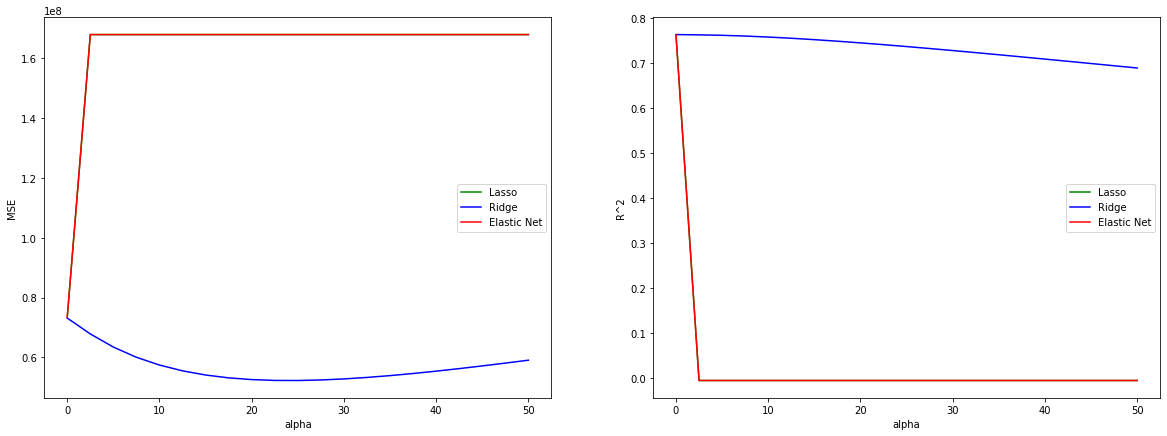

In [19]:
# plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(alpha_grid, alpha_mse[0], color='green', label='Lasso')
ax1.plot(alpha_grid, alpha_mse[1], color='blue', label='Ridge')
ax1.plot(alpha_grid, alpha_mse[2], color='red', label='Elastic Net')
ax1.legend()
ax1.set_xlabel('alpha')
ax1.set_ylabel('MSE')

ax2.plot(alpha_grid, alpha_r2[0], color='green', label='Lasso')
ax2.plot(alpha_grid, alpha_r2[1], color='blue', label='Ridge')
ax2.plot(alpha_grid, alpha_r2[2], color='red', label='Elastic Net')
ax2.legend()
ax2.set_xlabel('alpha')
ax2.set_ylabel('R^2')
plt.show()

In [20]:
np.min(alpha_mse, axis=1) # Ridge regression gives the best mse compared with Lasso and Elastic Net

array([73458240.0949395 , 52288299.55863302, 73458240.0949395 ])

In [21]:
alpha_grid[np.argmin(alpha_mse, axis=1)[1]] # Ridge regression with alpha = 25 gives the best mse

25.0

Surprisingly, the second model which I thought would outperform the first one actually produced larger MSE than the first model. What a disappointment!

## Non-Linear Regression Models

### Model 3: KNN Regression

The third model is non-linear KNN model. For this model, we also apply scaling because KNN is a distance based model. We test for K between 1 to 20 and we also test using different weights: uniform and distance. Uniform means all points in each neighborhood are weighted equally and distance means points are weighted by the inverse of their distance. In that case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [22]:
cv = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
scaler_s = StandardScaler() # scaler for 'bmi' column
scaler_m = MinMaxScaler() # scaler for 'age' column
max_K = 20
K_grid = list(range(1, (max_K+1)))
K_mse = np.zeros(shape=(2, max_K))

for num, k in enumerate(K_grid):
    mses = np.zeros(shape=(2, num_folds))
    for count, data in enumerate(cv.split(X_train)):
        train = data[0]; validation = data[1]
        x_t, x_v = X_train.iloc[train,:], X_train.iloc[validation,:]
        y_t, y_v = y_train[train], y_train[validation]

        # first do scaling on the training data (fit and transform)
        new_bmi = scaler_s.fit_transform(x_t[['bmi']])
        new_age = scaler_m.fit_transform(x_t[['age']])
        x_t['bmi'] = new_bmi
        x_t['age'] = new_age

        model_uni = KNeighborsRegressor(n_neighbors = k) # uniform weights
        model_dis = KNeighborsRegressor(n_neighbors = k, weights = 'distance') # distance weights
        model_uni.fit(x_t, y_t)
        model_dis.fit(x_t, y_t)

        # use information in the training data to scale the validation data (transform)
        new_bmi2 = scaler_s.transform(x_v[['bmi']])
        new_age2 = scaler_m.transform(x_v[['age']])
        x_v['bmi'] = new_bmi2
        x_v['age'] = new_age2

        # make prediction and calculate MSE
        # Uniform weights:
        y_pred = model_uni.predict(x_v)
        mse = mean_squared_error(y_v, y_pred)
        mses[0][count] = mse
        # Distance weights:
        y_pred = model_dis.predict(x_v)
        mse = mean_squared_error(y_v, y_pred)
        mses[1][count] = mse

    K_mse[0][num] = np.mean(mses[0])
    K_mse[1][num] = np.mean(mses[1])


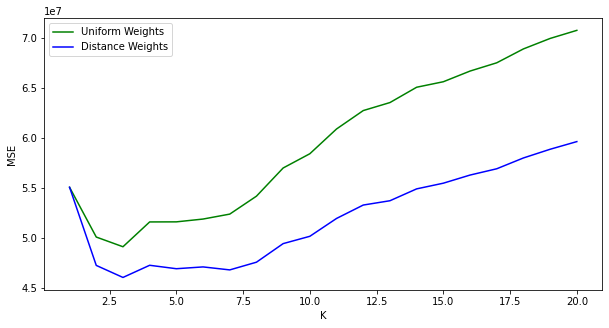

In [23]:
# plot the result
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(K_grid, K_mse[0], color='green', label='Uniform Weights')
ax.plot(K_grid, K_mse[1], color='blue', label='Distance Weights')
ax.legend()
ax.set_xlabel('K')
ax.set_ylabel('MSE')
plt.show()

In [24]:
np.min(K_mse, axis=1) # KNN regression with distance weights performs better than that with uniform distance weights

array([49143055.5291727 , 46076145.32222984])

In [25]:
K_grid[np.argmin(K_mse, axis=1)[1]] # KNN regression with distance weights with K = 3 gives the best mse

3

Still worse than the first model...

### Model 4: Random Forest Regression

For the fourth model we choose the random forest regression which is an ensemble model using bagging method. Note here we do not need to do scaling so we can directly employ **GridSearchCV** function to help us find the best hyperparameters. Here we tune 2 hyperparameters: n_estimators (the number of trees in the forest) and max_features (maximum number of features to choose from when do spliting). Both of them are used to control variance of the model and avoid overfitting.

In [26]:
n_estimators = [50,100,150,200,250,300,350,400]
max_features = ['auto', 'sqrt']
param_grid = {'n_estimators': n_estimators, 'max_features': max_features}
scoring = 'neg_mean_squared_error'
model = RandomForestRegressor(oob_score=True, random_state=seed)
cv = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv)
grid_result = grid.fit(X_train, y_train)

#best hyperparameters
print(grid_result.best_params_)
print(-grid_result.best_score_) #convert negative to positive mse

{'max_features': 'sqrt', 'n_estimators': 100}
24553319.496968977


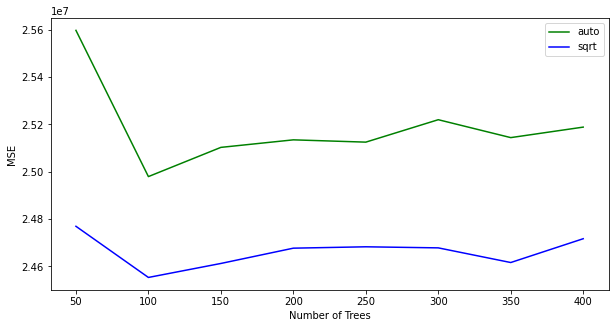

In [27]:
# plot the result
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][:len(n_estimators)], color='green', label='auto')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][len(n_estimators):], color='blue', label='sqrt')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
plt.show()

Finally better than the simple linear regression!

### Model 5: AdaBoost Regression

This is a ensemble model using boosting method. The same as the random forest model, it does not require scaling. We test the model on different n_estimators and learning_rate.

In [28]:
n_estimators = [5, 10, 20, 30, 40, 50, 100]
learning_rate = [0.001, 0.002, 0.005, 0.01, 0.02]
param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
scoring = 'neg_mean_squared_error'
model = AdaBoostRegressor(random_state=seed)
cv = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv)
grid_result = grid.fit(X_train, y_train)

#best hyperparameters
print(grid_result.best_params_)
print(-grid_result.best_score_) #convert negative to positive mse

{'learning_rate': 0.01, 'n_estimators': 20}
22858765.061768092


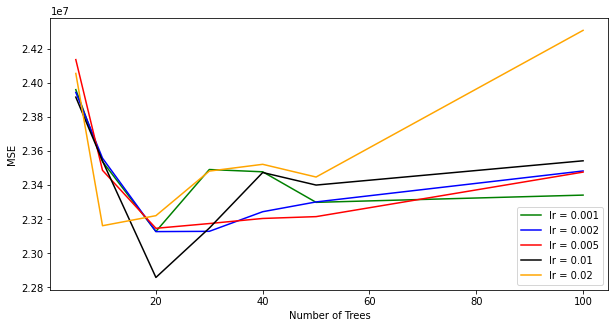

In [29]:
# plot the result
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][:len(n_estimators)], color='green', label='lr = 0.001')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][len(n_estimators): (2*len(n_estimators))], color='blue', label='lr = 0.002')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][(2*len(n_estimators)): (3*len(n_estimators))], color='red', label='lr = 0.005')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][(3*len(n_estimators)): (4*len(n_estimators))], color='black', label='lr = 0.01')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][(4*len(n_estimators)):], color='orange', label='lr = 0.02')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
plt.show()

Even better then the previous model.

### Model 6: LightGBM Regression

LightGBM is another ensemble model using boosting method and it has great performance in many competitions. Similar to model 5, we also select the best model from different n_estimators and learning_rate.

In [30]:
n_estimators = [50,100,150,200,250,300,350,400]
learning_rate = [0.001, 0.01, 0.02, 0.05, 0.1]
param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
scoring = 'neg_mean_squared_error'
model = LGBMRegressor(random_state=seed)
cv = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv)
grid_result = grid.fit(X_train, y_train)

#best hyperparameters
print(grid_result.best_params_)
print(-grid_result.best_score_) #convert negative to positive mse

{'learning_rate': 0.02, 'n_estimators': 150}
22598106.473595403


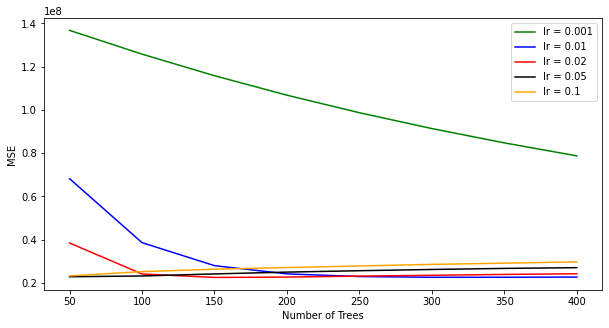

In [31]:
# plot the result
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][:len(n_estimators)], color='green', label='lr = 0.001')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][len(n_estimators): (2*len(n_estimators))], color='blue', label='lr = 0.01')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][(2*len(n_estimators)): (3*len(n_estimators))], color='red', label='lr = 0.02')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][(3*len(n_estimators)): (4*len(n_estimators))], color='black', label='lr = 0.05')
ax.plot(n_estimators, -grid_result.cv_results_['mean_test_score'][(4*len(n_estimators)):], color='orange', label='lr = 0.1')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
plt.show()

So far the best model!

# Compare Different Regression Models on Test Data

In [32]:
# build the six models
model1 = Lasso(alpha = 45)
model2 = Ridge(alpha = 25)
model3 = KNeighborsRegressor(n_neighbors=3, weights='distance')
model4 = RandomForestRegressor(oob_score=True, random_state=seed, n_estimators=100, max_features='sqrt')
model5 = AdaBoostRegressor(random_state=seed, n_estimators=20, learning_rate=0.01)
model6 = LGBMRegressor(random_state=seed, n_estimators=150, learning_rate=0.02)
models = [model1, model2, model3, model4, model5, model6]
y_pred_list = []
squared_error = []
mses = []
r_sqaured = []

# prepare another dataset for linear regression and KNN regression (scaling)
scaler_s = StandardScaler() # scaler for 'bmi' column
scaler_m = MinMaxScaler() # scaler for 'age' column
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()
new_bmi = scaler_s.fit_transform(X_train_scale[['bmi']])
new_age = scaler_m.fit_transform(X_train_scale[['age']])
X_train_scale['bmi'] = new_bmi
X_train_scale['age'] = new_age
new_bmi2 = scaler_s.transform(X_test_scale[['bmi']])
new_age2 = scaler_m.transform(X_test_scale[['age']])
X_test_scale['bmi'] = new_bmi2
X_test_scale['age'] = new_age2

#fit models, make predictions and calculate MSE and R-square
for num, model in enumerate(models):
    if num == 0 or num == 2:
        model.fit(X_train_scale, y_train)
        y_pred = model.predict(X_test_scale)
        y_pred_list.append(np.array(y_pred))
        squared_error.append(np.square(y_pred-y_test))
        mses.append(mean_squared_error(y_test, y_pred))
        r_sqaured.append(model.score(X_test_scale, y_test))
    elif num == 1:
        model.fit(X_train_scale, np.log(y_train))
        log_y_pred = model.predict(X_test_scale)
        y_pred = np.exp(log_y_pred)
        y_pred_list.append(np.array(y_pred))
        squared_error.append(np.square(y_pred-y_test))
        mses.append(mean_squared_error(y_test, y_pred))
        r_sqaured.append(model.score(X_test_scale, np.log(y_test)))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_list.append(np.array(y_pred))
        squared_error.append(np.square(y_pred-y_test))
        mses.append(mean_squared_error(y_test, y_pred))
        r_sqaured.append(model.score(X_test, y_test))



## True Values VS Predicted Values

The following six figures compares the distributions of predicted and true y-values for each model. We can clearly see the three ensemble models performs quite well since the two distributions are very similar. For the second model, which I place great expectations on, does not fit the pattern well for too few large predicted y-values.

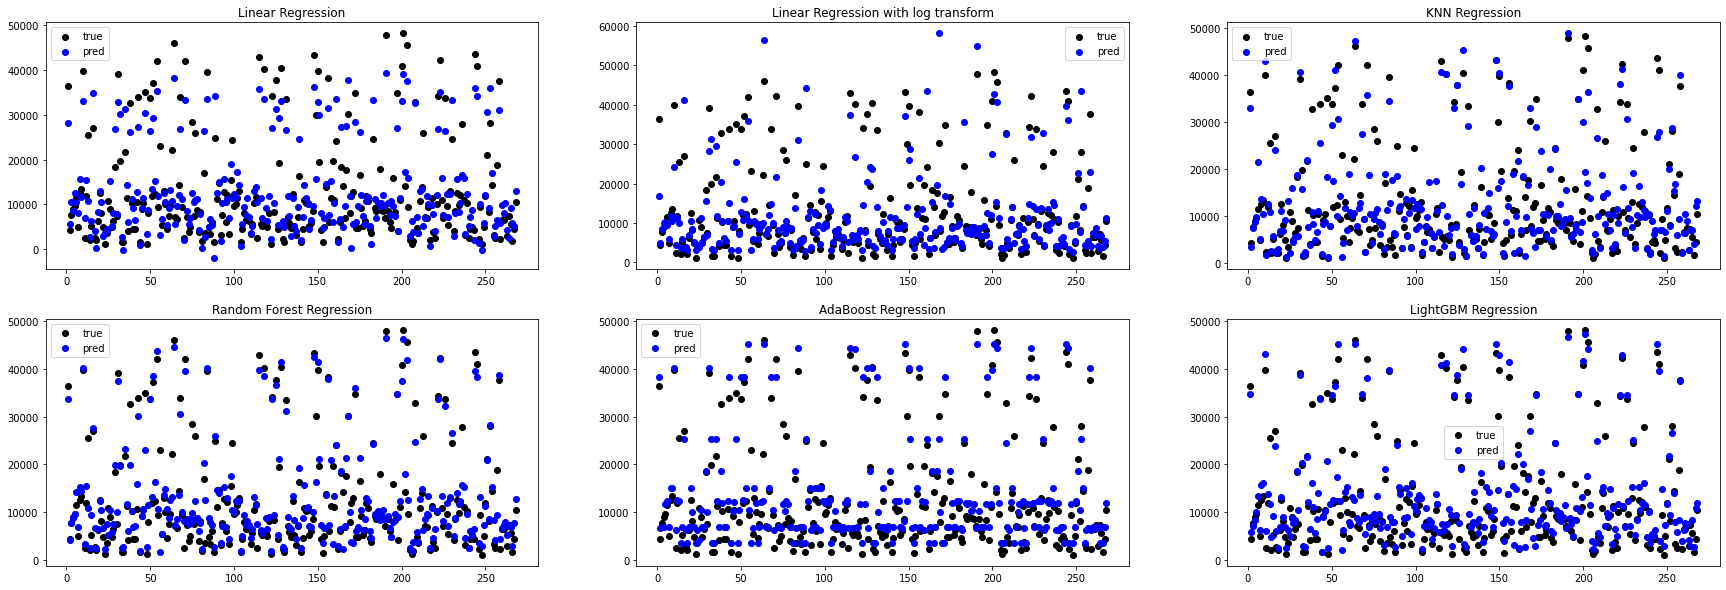

In [33]:
# True VS Pred
titles = ["Linear Regression", "Linear Regression with log transform", "KNN Regression", "Random Forest Regression", "AdaBoost Regression", "LightGBM Regression"]
fig, ax = plt.subplots(2, 3, figsize=(30,10))
for i in range(6):
    row = i//3
    col = i-3*row
    ax[row, col].scatter(list(range(1, len(y_test)+1)), y_test, color='black', label='true')
    ax[row, col].scatter(list(range(1, len(y_test)+1)), y_pred_list[i], color='blue', label='pred')
    ax[row, col].legend()
    ax[row, col].set_title(titles[i])
plt.show()

## Distribution of Sqaured Errors

The boxplot below plots all the squared errors for each models and gives more indication for the good performance of the three ensemble models. Most of the squared errors of these three models are small and they have relatively few outliers. In contrast, model 2 has lots of outliers (extremely big squared errors) and model 1 and model 3 have wider box.

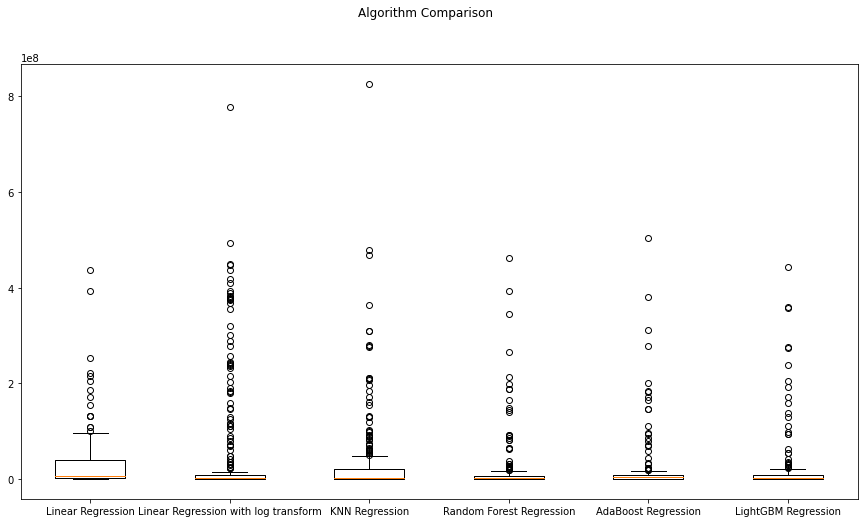

In [34]:
# compare squared errors distribution
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(squared_error)
ax.set_xticklabels(titles)
fig.set_size_inches(15,8)
plt.show()

## Coefficients for Linear Regression Models

Both the coefficients of age and smoker in the two linear regression models are very large, corresponding to the large positive correlation between *age, smoker* and *charges* we found in the correlation matrix in EDA section.
In addition, we notice the coefficients in model 1 are very large without the data scaling.

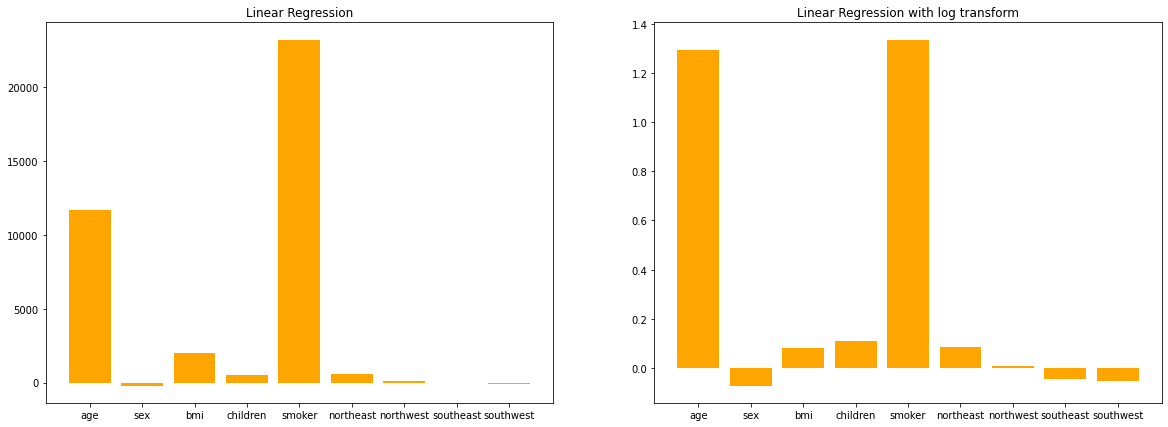

In [35]:
# coefficients for model1 and model2
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].bar(X_train.columns, model1.coef_, color='orange')
ax[0].set_title(titles[0])
ax[1].bar(X_train.columns, model2.coef_, color='orange')
ax[1].set_title(titles[1])
plt.show()

## Feature Importance for Tree Dicision Models

Both random forest regression and AdaBoost regression capture the most three important features (*age, bmi, smoker*) successfully, which also explains why they perform well. However, LightGBM regression model seems to overlook the most important feature *smoker* while it still perform better than the two linear regression models and the KNN regression model. This is a little bit weired.

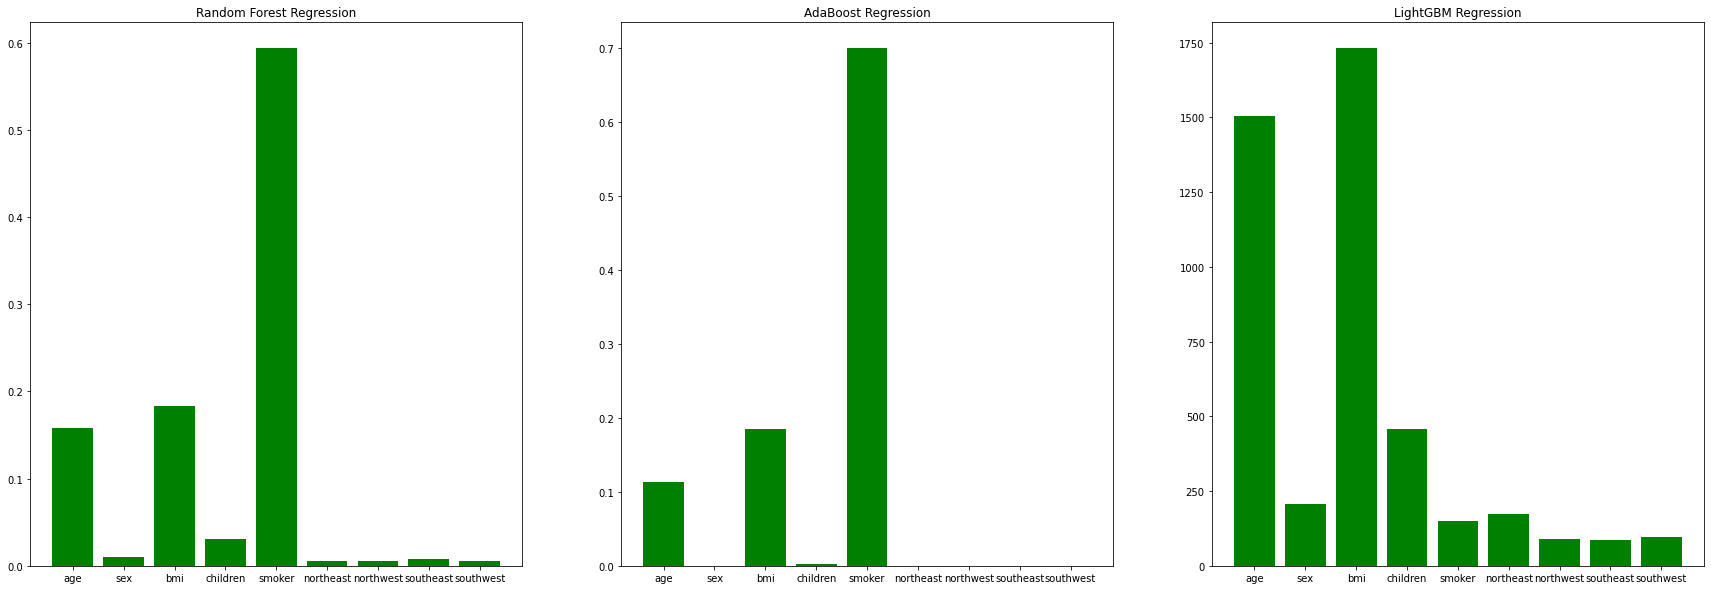

In [36]:
# feature importances for model4, model5 and model6
fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].bar(X_train.columns, model4.feature_importances_, color='green')
ax[0].set_title(titles[3])
ax[1].bar(X_train.columns, model5.feature_importances_, color='green')
ax[1].set_title(titles[4])
ax[2].bar(X_train.columns, model6.feature_importances_, color='green')
ax[2].set_title(titles[5])

plt.show()

## Comparison of MSEs and R-squares

The MSEs and R-squares below indicate the best model is AdaBoost Regression model with 20 trees and 0.01 learning rate.

In [37]:
# output MSEs
for i in range(6):
    print("MSE of %s: %f" % (titles[i], mses[i]))

MSE of Linear Regression: 27679983.677760
MSE of Linear Regression with log transform: 51436259.765954
MSE of KNN Regression: 32999528.482459
MSE of Random Forest Regression: 17223479.309071
MSE of AdaBoost Regression: 17157297.477788
MSE of LightGBM Regression: 17794509.498069


In [38]:
# output R-squares
for i in range(6):
    print("R^2 of %s: %f" % (titles[i], r_sqaured[i]))

R^2 of Linear Regression: 0.800394
R^2 of Linear Regression with log transform: 0.743815
R^2 of KNN Regression: 0.762033
R^2 of Random Forest Regression: 0.875798
R^2 of AdaBoost Regression: 0.876275
R^2 of LightGBM Regression: 0.871680


# Summary

According to the results, we see generally non-linear models perform better than linear models and ensemble models perform better than non-ensemble models in this case. This phenomenon indicates there exists non-linear relationship between the features and the response. Therefore, we can further do some feature engineering and try GAM and SVR models to capture the non-linear relationship within the data.

In the EDA section, although we found that the distribution of *charges* approaches to exponential, the model we built using the *log(charges)* as response perform even worse than the original linear regression model. Maybe taking the log also lead to lost of some information in the original data and lower the signal-to-noise ratio, just like when we take the log return in finance.

Lastly, when we perform the EDA section, we obviously feel the lack of features (or information). For example, we know the relationship between smoker and charges are very important but we only have a binary code for the smoker column, which is far from enough. We believe the lasting time of smoking, the frequency of smoking etc. are also very informative features that can polish our models.